# Récapitulatif de nos résultats

Ce notebook a pour but de présenter nos travaux sur ce projet, et notamment les performances de différents modèles que nous avons utilisé.

In [81]:
# pour que, quand une fonction de recap.py est changée, on ait pas besoin de relancer cette cellule
# import autoreload
%load_ext autoreload
%autoreload 2
try:
    from recap import *
except:
    from recap.recap import *

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

df_scrap, df_label, df_gen = load_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Statistiques sur nos différentes bases de données

### BDD générée par LLM

Cette BDD a été construite en utilisant le LLM `XWIN-b7` basé sur Llama-2. 

In [86]:
show_info(df_gen, "BDD Générée")

- Nombre de tweets : 442
- Nombre de sujets : 12


### BDD scrapée depuis Twitter

Cette BDD a été récupérée _via_ l'API de Twitter lorsqu'elle était encore gratuite.

In [87]:
show_info(df_scrap, "BDD scrapée")

- Nombre de tweets : 90152
- Nombre de sujets : 212


In [88]:
show_info(df_label, "BDD labelisée à la main")

- Nombre de tweets : 298
- Nombre de sujets : 154


## 2. Analyses des performances des LLM sur la BDD générée


#### Topic

In [85]:
# évaluation des prédictions

preds = pd.read_csv(os.path.join("results","res_topic_2000_comp.csv"))
try:
    preds.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "index"], inplace=True)
except: pass

def score_true_topic(truth, pred_labels, pred_scores):
    """
    score = confiance du modèle pour le vrai topic
    """
    # print(truth, pred_labels)
    try:
        return pred_scores[ pred_labels.index(truth) ]
    except ValueError:
        return 0


def score_best_topic(truth, pred_labels, pred_scores):
    """
    score = 1 si le topic avec le plus haut score est le même que le vrai topic
            0 sinon
    """
    try:
        return truth == pred_labels[0]
    except IndexError: # aucune prédiction (pas censé arriver !)
        return 0
def score_threshold_topic(truth, pred_labels, pred_scores, threshold=0.8):
    """
    score = 1 si la confiance du modèle pour le vrai topic est supérieur au threshold
            0 sinon
    """
    try:
        return pred_scores[ pred_labels.index(truth) ] > 0.8
    except ValueError:
        return 0
    
threshold = 0.8

accu_true_topic = 0
accu_best_topic = 0
accu_thresh     = 0
n=len(preds)
preds["labels"] = preds["labels"].map(eval)
preds["scores"] = preds["scores"].map(eval)
for id,truth, pred_labels, pred_scores in preds[["topic","labels","scores"]].itertuples(index=True, name=None):
    # pred_labels = eval(pred_labels)
    # pred_scores = eval(pred_scores)
    accu_true_topic += score_true_topic(truth, pred_labels, pred_scores)
    accu_best_topic += score_best_topic(truth, pred_labels, pred_scores)
    accu_thresh += score_threshold_topic(truth, pred_labels, pred_scores, threshold)

print(f"Confiance moyenne du modèle pour le vrai topic : {accu_true_topic/n:.2f}")
print(f"Nombre de prédictions où le meilleur topic (selon le modèle) est le vrai topic : "
      f"{accu_best_topic} ({accu_best_topic/n:.2%})")
print(f"Nombre de prédictions où le vrai topic a un score supérieur à {threshold} : "
      f"{accu_thresh} ({accu_thresh/n:.2%})")


conf_par_sujet = {}
for sujet in preds["topic"].unique():
    all_sujet = preds[preds["topic"] == sujet]
    conf_par_sujet[sujet] = sum(
        score_best_topic(sujet, pred_labels, pred_scores) 
        for pred_labels, pred_scores in all_sujet[["labels","scores"]].itertuples(index=False,name=None)
    ) / len(all_sujet)





Confiance moyenne du modèle pour le vrai topic : 0.81
Nombre de prédictions où le meilleur topic (selon le modèle) est le vrai topic : 1143 (57.15%)
Nombre de prédictions où le vrai topic a un score supérieur à 0.8 : 1505 (75.25%)


#### Sentiment

accuracy : 0.45491954629385384


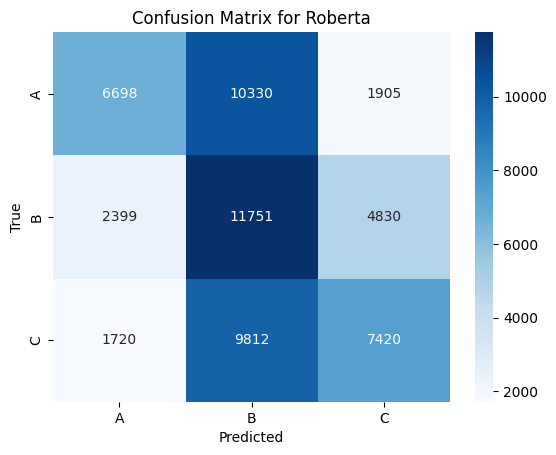

              precision    recall  f1-score   support

        -1.0       0.62      0.35      0.45     18933
         0.0       0.37      0.62      0.46     18980
         1.0       0.52      0.39      0.45     18952

    accuracy                           0.45     56865
   macro avg       0.50      0.45      0.45     56865
weighted avg       0.50      0.45      0.45     56865



In [91]:
df = pd.read_csv("results/res_gen_sent_3_classes.csv")

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

df_tested = df[~df.sentiment_pred.isna()]
df_tested["sentiment"] = df_tested["label"].map(
    lambda x : 0.0 if x == "neutre" else 1.0 if x == "positif" else -1.0
)


# df_tested_no_neutral = df_tested[(df_tested["sentiment"] != 0) & (df_tested["sentiment_pred"] != 0]

acc = accuracy_score(df_tested['sentiment'], df_tested['sentiment_pred'])
print(f"accuracy : {acc}")

cm = confusion_matrix(df_tested['sentiment'], df_tested['sentiment_pred'])

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["A", "B", "C"],
    yticklabels=["A", "B", "C"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Roberta")
plt.show()

print(classification_report(df_tested['sentiment'], df_tested['sentiment_pred']))

## 3. Test semi-interractif de nos modèles

In [3]:
# chargement du modèle
from transformers import pipeline
from preprocessing import preprocess_text

print("Chargement du modèle twitter-xlm-roberta-base-sentiment-finetunned (peut prendre quelques minutes)")
try:
    classifier_sentiment = pipeline("text-classification", model="citizenlab/twitter-xlm-roberta-base-sentiment-finetunned")
except:
    print("Il y a eu un problème, deuxième tentative avec from_pt=True")
    classifier_sentiment = pipeline("text-classification", model="citizenlab/twitter-xlm-roberta-base-sentiment-finetunned", model_kwargs={"from_pt":True})

print("Chargement du modèle camembert-base-xnli")

topic_classifier = pipeline("zero-shot-classification", model="mtheo/camembert-base-xnli", multi_label=True)

    # print("Il y a eu un problème, deuxième tentative avec from_pt=True")
    # topic_classifier = pipeline("zero-shot-classification", model="mtheo/camembert-base-xnli", device=0, multi_label=True, model_kwargs={"from_pt":True})


[nltk_data] Downloading package stopwords to /home/pernas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pernas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pernas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Chargement du modèle twitter-xlm-roberta-base-sentiment-finetunned (peut prendre quelques minutes)
Chargement du modèle camembert-base-xnli


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

In [94]:
# tweet (ou n'importe quel texte pas trop long)
tweet = "Le succès ne consiste pas à ne jamais faire d'erreur mais à ne jamais faire la même erreur deux fois"

# traitement...
tweet = preprocess_text(tweet, stem_lemm=None)
pred_sent = classifier_sentiment.predict(tweet)[0]
pred_topic = topic_classifier([tweet], topics, multi_label=True, hypothesis_template="Ce tweet parle de {}.")[0]
sent = pred_sent["label"]
score_sent = pred_sent["score"]
topics = pred_topic["labels"]
topics_score = pred_topic["scores"]

print("Prédictions :")
print(f" - Sentiment : {sent}, confiance : {score_sent:.3f}")
print(f" - Topic dominant   : {topics[0]} (confiance : {topics_score[0]})")
print(f" - Topic secondaire : {topics[1]} (confiance : {topics_score[1]})")



Prédictions :
 - Sentiment : Neutral, confiance : 0.961
 - Topic dominant   : Actualités (confiance : 0.5454986691474915)
 - Topic secondaire : Entreprise (confiance : 0.40949079394340515)
